In [82]:
import torch
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary
import os

In [72]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10データセットのダウンロードと変換
train_dataset = datasets.CIFAR10("data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10("data", train=False, download=True, transform=transform)

# 80%を訓練データ、20%を検証データに分割し、サンプラーを作成
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
validation_size = 0.2
split = int(np.floor(validation_size * num_train))
train_index, validation_index = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_index)
validation_sampler = SubsetRandomSampler(validation_index)

# データローダーの作成
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
validation_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=validation_sampler)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

# CIFAR-10のクラス
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


Files already downloaded and verified
Files already downloaded and verified


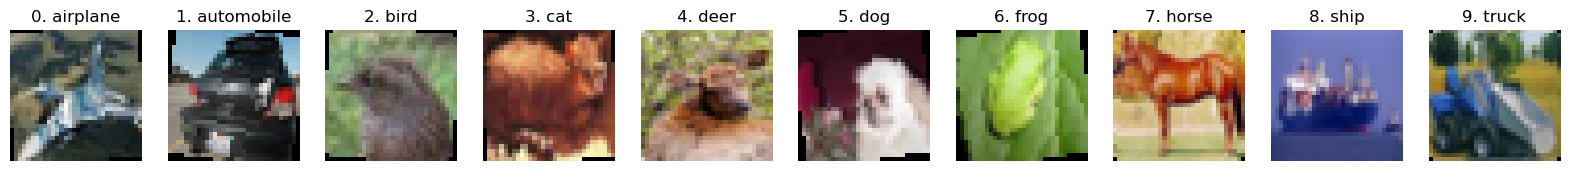

In [73]:
# CIFAR-10の画像を表示
first_batch = next(iter(train_data_loader))
class_index = 0
fig = plt.figure(figsize=(20, 2))
for batch in train_data_loader:
    if class_index > 10: break
    for image, label in zip(*batch):
        if class_index > 10: break
        if label == class_index:
            fig.add_subplot(1, 10, class_index + 1)
            image = image / 2 + 0.5 # -1から1の範囲を0から1に変換
            plt.imshow(image.permute(1, 2, 0)) # チャンネルを最後に並び替え
            plt.title(f"{class_index}. {classes[class_index]}")
            plt.axis("off")
            class_index += 1


Text(0.5, 1.0, 'ELU activation function')

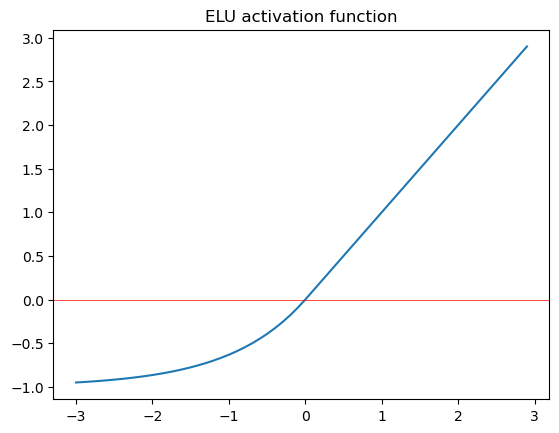

In [74]:
# ELU活性化関数
# 負の値がありバッチ正規化のように低い計算量で汎化する
xs = np.arange(-3, 3, 0.1)
plt.plot(xs, [F.elu(torch.tensor(x)).item() for x in xs])
plt.axhline(0, color="r", linewidth=0.5)
plt.title("ELU activation function")

In [79]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # (32-3+2*1)/1+1=32
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # (16-3+2*1)/1+1=16
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # (8-3+2*1)/1+1=8
        self.pool = nn.MaxPool2d(2, 2) # (32-2)/2+1=16, (16-2)/2+1=8, (8-2)/2+1=4
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x))) # 32x32 -> 32x32 -> 16x16
        x = self.pool(F.elu(self.conv2(x))) # 16x16 -> 16x16 -> 8x8
        x = self.conv3(x)
        x = self.pool(F.elu(x)) # 8x8 -> 8x8 -> 4x4
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

エポック:1, バッチ:1/625, 訓練データ損失:2.302110
エポック:1, バッチ:101/625, 訓練データ損失:2.278050
エポック:1, バッチ:201/625, 訓練データ損失:2.255569
エポック:1, バッチ:301/625, 訓練データ損失:2.132427
エポック:1, バッチ:401/625, 訓練データ損失:1.978348
エポック:1, バッチ:501/625, 訓練データ損失:1.860854
エポック:1, バッチ:601/625, 訓練データ損失:2.003563
エポック:1, 訓練データ損失:1.716695, 検証データ損失:0.390020
モデルを保存しました: models/cnnnet.pth
エポック:2, バッチ:1/625, 訓練データ損失:2.019690
エポック:2, バッチ:101/625, 訓練データ損失:1.909028
エポック:2, バッチ:201/625, 訓練データ損失:1.968886
エポック:2, バッチ:301/625, 訓練データ損失:1.802614
エポック:2, バッチ:401/625, 訓練データ損失:1.835196
エポック:2, バッチ:501/625, 訓練データ損失:1.883299
エポック:2, バッチ:601/625, 訓練データ損失:1.715738
エポック:2, 訓練データ損失:1.510119, 検証データ損失:0.349782
モデルを保存しました: models/cnnnet.pth
エポック:3, バッチ:1/625, 訓練データ損失:1.869710
エポック:3, バッチ:101/625, 訓練データ損失:1.739053
エポック:3, バッチ:201/625, 訓練データ損失:1.665879
エポック:3, バッチ:301/625, 訓練データ損失:1.896969
エポック:3, バッチ:401/625, 訓練データ損失:1.716023
エポック:3, バッチ:501/625, 訓練データ損失:1.545513
エポック:3, バッチ:601/625, 訓練データ損失:1.676509
エポック:3, 訓練データ損失:1.349685, 検証データ損失:0.316674
モデルを保存しました: models/

Text(0, 0.5, 'Cross Entropy Loss')

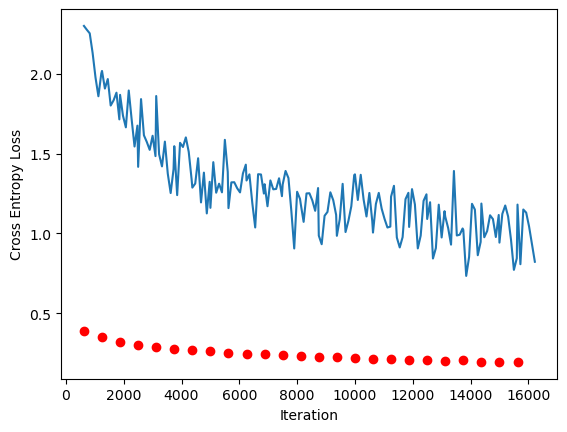

In [84]:
model = CNNNet()
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_log_x = []
train_log_y = []
validation_log_x = []
validation_log_y = []
minimum_loss = np.inf

for epoch in range(1, 26):
    train_loss = 0.
    validation_loss = 0.
    model.train()

    for index, (data, target) in enumerate(train_data_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

        if index % 100 == 0:
            train_log_x.append(epoch * len(train_data_loader) + index)
            train_log_y.append(loss.item())
            print(f"エポック:{epoch}, バッチ:{index + 1}/{len(train_data_loader)}, 訓練データ損失:{loss.item():6f}")

    
    model.eval()
    for data, target in validation_data_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)
        validation_loss += loss.item() * data.size(0)

    train_loss = train_loss / len(train_data_loader.dataset)
    validation_loss = validation_loss / len(validation_data_loader.dataset)

    validation_log_x.append(epoch * len(train_data_loader))
    validation_log_y.append(validation_loss)
    print(f"エポック:{epoch}, 訓練データ損失:{train_loss:6f}, 検証データ損失:{validation_loss:6f}")

    os.makedirs("models", exist_ok=True)
    if minimum_loss > validation_loss:
        save_path = f"models/cnnnet.pth" 
        torch.save(model.state_dict(), save_path)
        print(f"モデルを保存しました: {save_path}")

plt.plot(train_log_x, train_log_y, label="train")
plt.scatter(validation_log_x, validation_log_y, label="validation", color="r")
plt.xlabel("Iteration")
plt.ylabel("Cross Entropy Loss")

In [94]:
model.load_state_dict(torch.load("models/cnnnet.pth"))

test_loss = 0.
class_correct = [0.] * 10
class_total = [0.] * 10

model.eval()

for data, target in test_data_loader:
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, predicted = torch.max(output, 1)
    correct = np.squeeze(predicted.eq(target.data.view_as(predicted)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_data_loader.dataset)

for i in range(10):
    print(f"クラス:{classes[i]}, 正解率:{100 * class_correct[i] / class_total[i]:6f}%")

print(f"総正解率:{100 * np.sum(class_correct) / np.sum(class_total):6f}%")

/tmp/ipykernel_280433/2282810785.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/cnnnet.pth"))


クラス:airplane, 正解率:71.400000%
クラス:automobile, 正解率:79.100000%
クラス:bird, 正解率:61.300000%
クラス:cat, 正解率:42.000000%
クラス:deer, 正解率:45.700000%
クラス:dog, 正解率:55.100000%
クラス:frog, 正解率:79.100000%
クラス:horse, 正解率:74.100000%
クラス:ship, 正解率:82.600000%
クラス:truck, 正解率:69.800000%
総正解率:66.020000%
